<a href="https://colab.research.google.com/github/DavoodSZ1993/Pytorch_Basics/blob/main/5_mlp_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## `nn.ReLU()` vs. `nn.functional.relu()`:

* `nn.ReLU`: Creates an `nn.Module` which can be added to an `nn.Sequential` model.
* `nn.functional.relu()`: Is just the functional API call to the relu function. So it can be added in forward method.

## `tensor.backward()`

Computes the gradient of the current tensor w.r.t.  graph leaves.

* By default, PyTorch expects `backward()` to be called for the **last** output of the network, **the loss function**.
* By default, `backward()` is called on a **scalar tensor** and expects no arguments.  

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch

In [16]:
a = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]], requires_grad=True)
b = a * a

b.backward(a)
print(a.grad)

tensor([[ 2.,  8., 18.],
        [32., 50., 72.]])


* In the above code snippet, the `backward()` is called on a 2x3 `b` tensor (no longer a scalar). Mathematically, `a.grad` should be a 2x3x2x3 tensor as follows:
$$
db[i, j] / da[k, l]
$$



* `torch.ones_like()`: Returns a tesnor filled with the scalar value 1, with the same size as `input`.

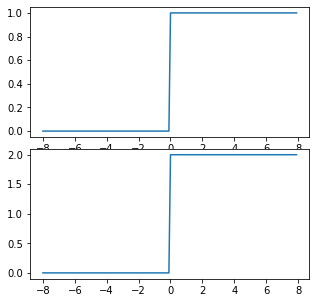

In [13]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)


fig = plt.figure(1, figsize=(5, 5))
gs = gridspec.GridSpec(4, 4)

y.backward(torch.ones_like(x), retain_graph=True)
first_plot = fig.add_subplot(gs[0:2, 0:4])
plt.plot(x.detach(), x.grad)

x.grad.data.zero_()
y.backward(torch.ones_like(x) * 2, retain_graph=True)
first_plot = fig.add_subplot(gs[2:4, 0:4])
plt.plot(x.detach(), x.grad)